In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [14]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [20]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [21]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [22]:
train_df2 = train_df[train_df['vas_id']==2]
test_df2 = test_df[test_df['vas_id']==2]

In [23]:
train_df2.vas_id_02.value_counts()

1    149006
2       480
Name: vas_id_02, dtype: int64

In [24]:
test_df2.vas_id_02.value_counts()

1.0    99471
2.0      548
Name: vas_id_02, dtype: int64

In [25]:
train_df2.target.value_counts(normalize=True)

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

In [26]:
test_df2.target.value_counts(normalize=True)

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

In [27]:
train_df2.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
0,513035,2.0,1544994000,-55.769970,289.330902,-69.710785,239.263199,-75.128242,218.158203,-10.15618,...,0,0,12,351,51,1546203600,1209600,0,0,0.0
2,3833972,2.0,1531688400,422.270020,134.200882,565.519226,264.203217,560.101746,247.338211,-16.08618,...,0,0,7,197,29,1546203600,14515200,0,0,0.0
4,2601637,2.0,1539550800,-92.219971,-177.999115,-106.160789,-230.606796,-111.578247,-251.711792,-16.08618,...,0,0,10,288,42,1546203600,6652800,0,0,0.0
5,319303,2.0,1531688400,-86.199974,-389.099121,-100.140785,-441.706787,-105.558243,458.408203,-16.08618,...,0,0,7,197,29,1546203600,14515200,0,0,0.0
7,85652,2.0,1544389200,-81.559967,-152.699112,-95.500786,-205.306793,-100.918243,-226.411789,-16.08618,...,0,0,12,344,50,1546203600,1814400,0,0,0.0
9,3336114,2.0,1544994000,-96.799973,72.750885,-110.740784,22.683201,-116.158249,1.578210,-16.08618,...,0,0,12,351,51,1546203600,1209600,0,0,0.0
10,365854,2.0,1540760400,-96.799973,18.610888,-110.740784,-8.566798,-116.158249,-29.671789,-16.08618,...,0,0,10,302,44,1546203600,5443200,0,0,0.0
11,1667099,2.0,1543179600,-60.769970,-164.849106,-62.000786,-196.266800,-67.418243,-217.371796,-16.08618,...,0,0,11,330,48,1546203600,3024000,0,0,0.0
12,3885477,2.0,1531688400,-39.329971,-129.579117,-44.380787,-130.116791,-49.798244,-151.221786,11.87382,...,0,0,7,197,29,1546203600,14515200,0,0,0.0
18,2307496,2.0,1534712400,108.120026,-75.819115,94.179214,-94.526794,203.151749,36.888210,-16.08618,...,0,0,8,232,34,1546203600,11491200,0,0,0.0


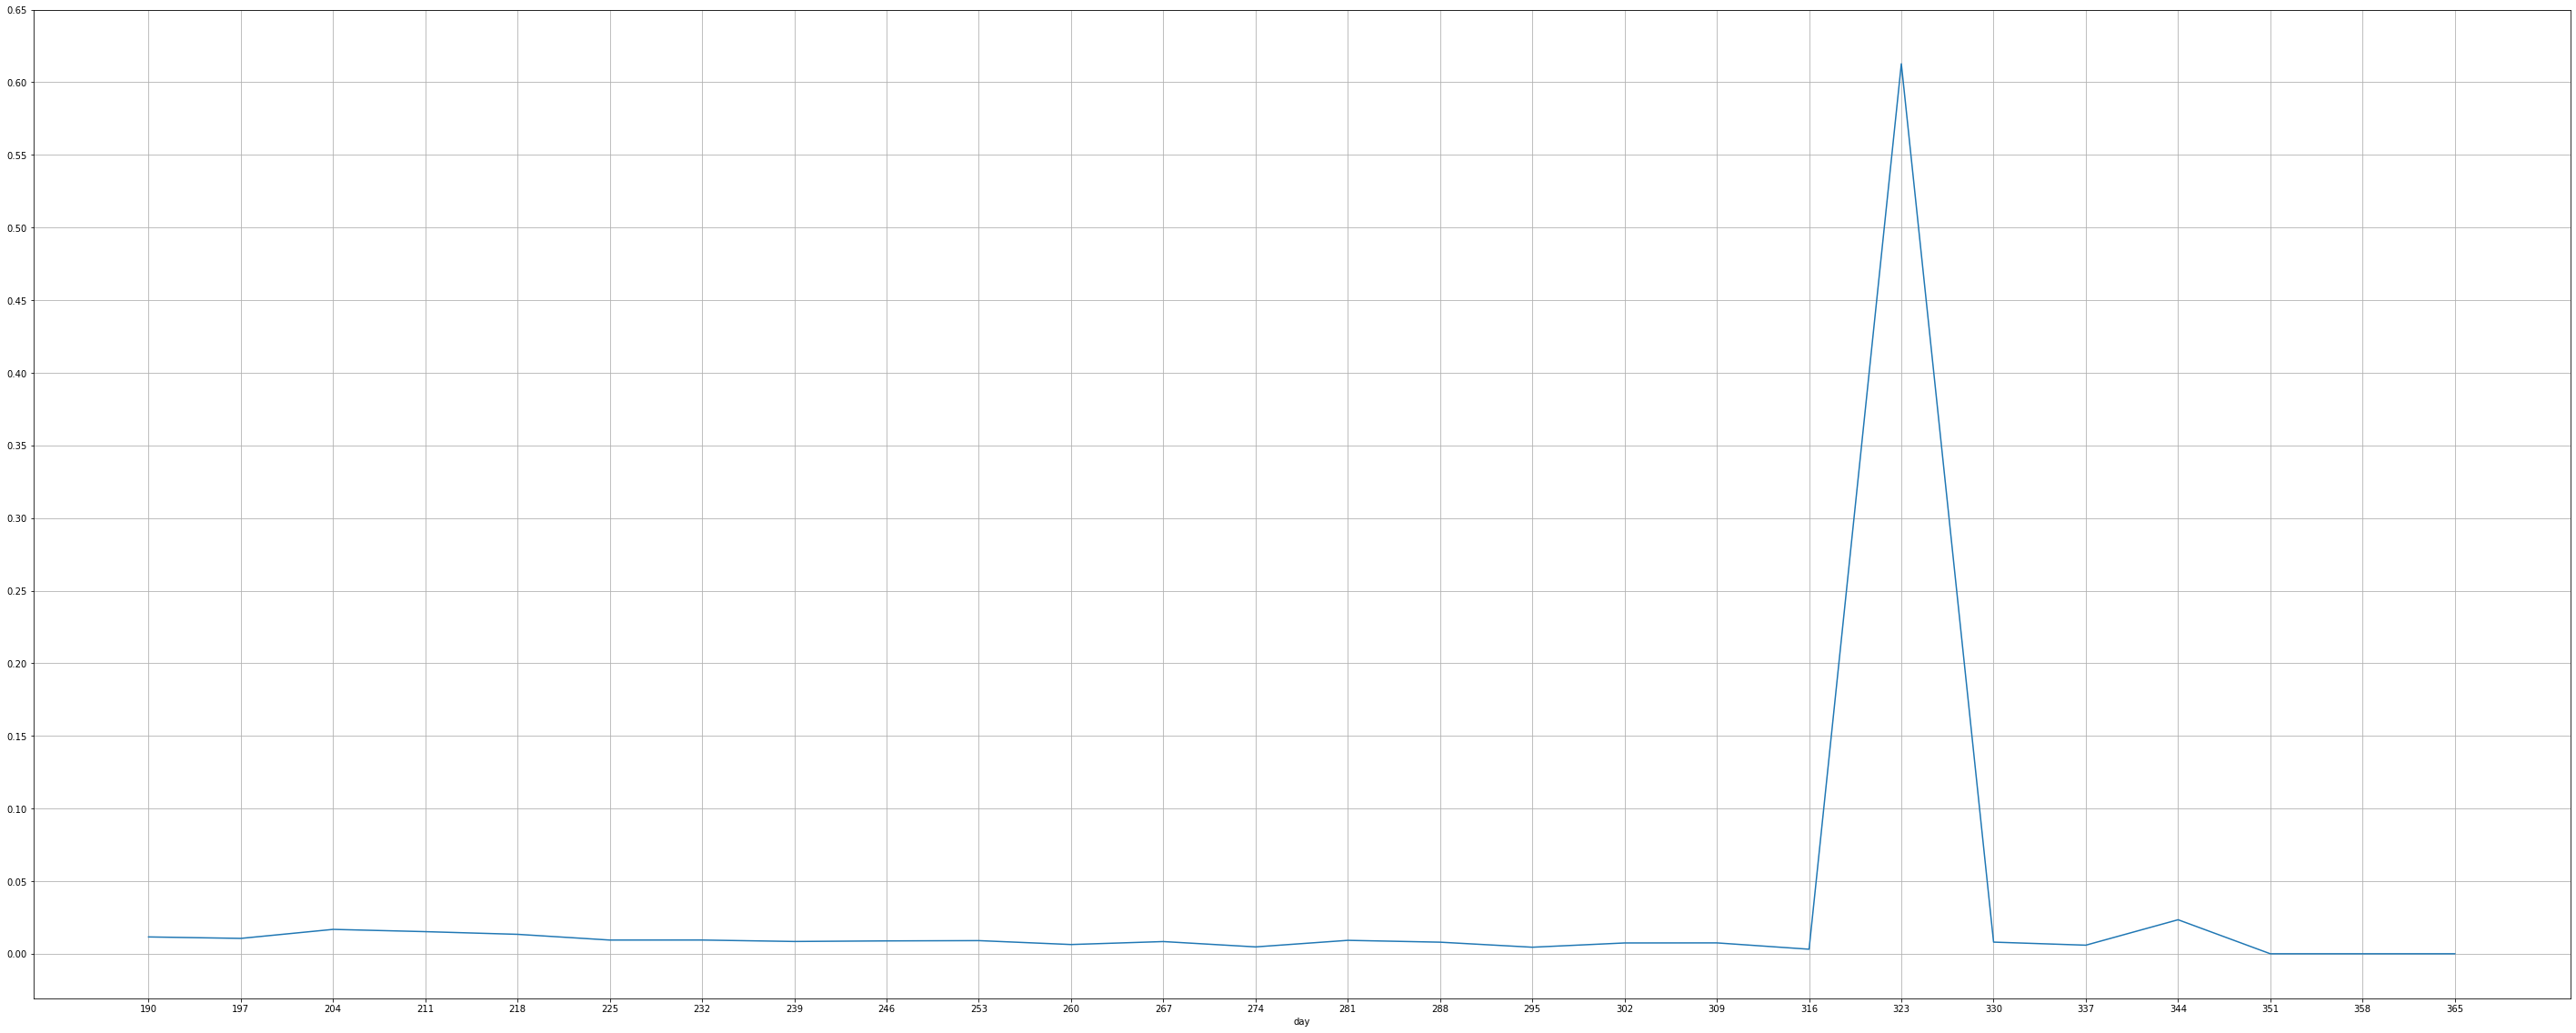

In [28]:
plt.figure(figsize=(50, 20))
train_df2.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df2['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 330 день.

# Разбиение на  train  и  test

In [29]:
TARGET_NAME = 'target'

In [30]:
X_train = train_df2.drop(columns=[TARGET_NAME])
y_train = train_df2[TARGET_NAME]
X_test = test_df2.drop(columns=[TARGET_NAME])
y_test = test_df2[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

In [31]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    146633
1.0    145503
Name: target, dtype: int64

In [32]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [32]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [33]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [34]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [35]:
list_spy.remove('vas_id')

In [36]:
#df_categorical = df_all[list_spy]

In [37]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [38]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [39]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [40]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [41]:
cat_feats = Categorical_features.columns.to_list()

In [42]:
cat_feats

[]

In [43]:
#df4[list_spy] = df4[list_spy].astype('object')

In [44]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [45]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [33]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

51.39607430774623

In [38]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.007766162896985

scale_pos_weight не помог

# XGBClassifier

In [46]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [47]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [48]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    146633
         1.0       0.98      0.69      0.81      2853

    accuracy                           0.99    149486
   macro avg       0.98      0.84      0.90    149486
weighted avg       0.99      0.99      0.99    149486

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     98075
         1.0       0.69      0.41      0.51      1944

    accuracy                           0.98    100019
   macro avg       0.84      0.70      0.75    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     97713  362
1.0      1151  793


 macro avg       0.83      0.69      0.74    100019

Подобрал learning_rate от переобучения

In [49]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [50]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    146633
         1.0       0.99      0.98      0.99    145503

    accuracy                           0.99    292136
   macro avg       0.99      0.99      0.99    292136
weighted avg       0.99      0.99      0.99    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     98075
         1.0       0.44      0.61      0.51      1944

    accuracy                           0.98    100019
   macro avg       0.71      0.80      0.75    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     96549  1526
1.0       763  1181


macro avg       0.71      0.79      0.74    100019

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [51]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.92 (+/- 0.00)


In [52]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [53]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [54]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    146633
         1.0       0.87      0.58      0.69      2853

    accuracy                           0.99    149486
   macro avg       0.93      0.79      0.84    149486
weighted avg       0.99      0.99      0.99    149486

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     98075
         1.0       0.70      0.40      0.51      1944

    accuracy                           0.98    100019
   macro avg       0.84      0.70      0.75    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     97733  342
1.0      1159  785


macro avg       0.83      0.71      0.76    100019

In [55]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.96 (+/- 0.00)

In [56]:
model_lgbm = LGBMClassifier(random_state=21)

In [57]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    146633
         1.0       0.98      0.94      0.96    145503

    accuracy                           0.96    292136
   macro avg       0.96      0.96      0.96    292136
weighted avg       0.96      0.96      0.96    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     98075
         1.0       0.42      0.66      0.51      1944

    accuracy                           0.98    100019
   macro avg       0.71      0.82      0.75    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     96311  1764
1.0       664  1280


macro avg       0.69      0.81      0.73    100019

In [58]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.96 (+/- 0.00)

In [59]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [34]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [35]:
model_catb = catb.CatBoostClassifier(**frozen_params)

reg_lambda не сильно но помогла с переобучением

In [36]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.68      1.00      0.81      2853

    accuracy                           0.99    149486
   macro avg       0.84      1.00      0.90    149486
weighted avg       0.99      0.99      0.99    149486

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.56      0.63      0.59      1944

    accuracy                           0.98    100019
   macro avg       0.77      0.81      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97098   977
1.0       717  1227


In [37]:
run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.80 (+/- 0.01)


In [39]:
frozen_params2 = {
     'class_weights':[1, 1], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [40]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [41]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.59      0.62      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.80      0.80    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97229   846
1.0       747  1197


macro avg       0.79      0.80      0.80    100019

In [42]:
run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

model_catb: f1_macro = 0.99 (+/- 0.00)


In [70]:
#show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

# RandomForestClassifier

In [71]:
model_RF = RandomForestClassifier(random_state=21, class_weight={0:.5, 1:.5})

RandomForestClassifier без ccp_alpha дает полное переобучение на трейне, ввел коэффициент.

In [72]:
feature_importances = train_evaluate_preds(model_RF, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    146633
         1.0       1.00      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.65      0.48      0.56      1944

    accuracy                           0.98    100019
   macro avg       0.82      0.74      0.77    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     97567  508
1.0      1002  942


macro avg       0.82      0.73      0.76    100019

In [73]:
#run_cv(model_RF, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_RF");

model_RF: f1_macro = 1.00 (+/- 0.00)


In [74]:
model_RF2 = RandomForestClassifier(random_state=21, class_weight={0:.98, 1:.02})

In [75]:
feature_importances2 = train_evaluate_preds(model_RF2, X_train, X_test, y_train, y_test)

0.0    0.980915
1.0    0.019085
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    146633
         1.0       1.00      1.00      1.00      2853

    accuracy                           1.00    149486
   macro avg       1.00      1.00      1.00    149486
weighted avg       1.00      1.00      1.00    149486

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     98075
         1.0       0.66      0.47      0.55      1944

    accuracy                           0.98    100019
   macro avg       0.82      0.73      0.77    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     97604  471
1.0      1030  914


macro avg       0.82      0.73      0.76    100019

In [76]:
#run_cv(model_RF2, kfold_cv, X_train, y_train, model_name="model_RF");

model_RF2: f1 = 0.52 (+/- 0.01)


In [77]:
#show_learning_curve_plot(model_RF, X_train_balanced, y_train_balanced)

По результатам отборочных туров, главным тренером команды назначен CatBoostClassifier

# Выбор метода балансировки датасета

In [78]:
df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [79]:
X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [80]:
disbalance_t = y_train_tomek.value_counts()[0] / y_train_tomek.value_counts()[1]
disbalance_t

51.01296880476691

In [81]:
frozen_params_t = {
     'class_weights':[1, disbalance_t], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [82]:
model_catb_t = catb.CatBoostClassifier(**frozen_params_t)

In [83]:
feature_importances = train_evaluate_preds(model_catb_t, X_train_tomek, X_test, y_train_tomek, y_test)

0.0    0.980774
1.0    0.019226
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    145540
         1.0       0.74      1.00      0.85      2853

    accuracy                           0.99    148393
   macro avg       0.87      1.00      0.92    148393
weighted avg       0.99      0.99      0.99    148393

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.56      0.63      0.59      1944

    accuracy                           0.98    100019
   macro avg       0.77      0.81      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97089   986
1.0       714  1230


In [84]:
df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [85]:
X_train_smote= df_smote.drop(columns=TARGET_NAME)
y_train_smote = df_smote[TARGET_NAME]

In [86]:
disbalance_s = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]
disbalance_s

1.0

In [87]:
frozen_params_s = {
     'class_weights':[1, disbalance_s], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [88]:
model_catb_s = catb.CatBoostClassifier(**frozen_params_s)

In [89]:
feature_importances = train_evaluate_preds(model_catb_s, X_train_smote, X_test, y_train_smote, y_test)

1.0    0.5
0.0    0.5
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    146633
         1.0       1.00      0.99      0.99    146633

    accuracy                           0.99    293266
   macro avg       0.99      0.99      0.99    293266
weighted avg       0.99      0.99      0.99    293266

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     98075
         1.0       0.67      0.45      0.54      1944

    accuracy                           0.99    100019
   macro avg       0.83      0.72      0.77    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     97643  432
1.0      1068  876


In [90]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [91]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.59      0.62      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.81      0.80    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97220   855
1.0       738  1206


In [92]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [93]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced[fea_imp], X_test[fea_imp], y_train_balanced, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.58      0.61      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.80      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97216   859
1.0       754  1190


In [43]:
X_train = X_train_balanced
#X_test = X_test[fea_imp]
y_train = y_train_balanced

# Удаление признаков

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [101]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [102]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [103]:
selector.ranking_

array([120,   1,   1,   1,  95,   1,  84,   1,  85,   1,  69,   1,  68,
         1,   1,   1,  49,   1,   1,   1,   2,   1,   1,   1,  92,   1,
        21,  25,  51,   1,   1,   1,   1,   1,   1,   1,   1,  80,  17,
         1, 105,   1,   1,   1,   6,  20,   1,   1,   1,   1,  96,  98,
       111,   1,   1,  91,  37,   1,  66,  36,   1,  60,  29,   1,  47,
         1,   1,   1,   1,   1,   1,  14,   1,   1,   1,   1,   1,  22,
       101,  75,  65,   1,   1,   1,  99,  24,   1,  13, 113,  83,   1,
         1,  44,  56,   1,   1,   1,  76,   1,  34,  55,  45, 110,  86,
         4,   3,  46,   8,   5,  58,  90,  48,  15,   1,  82,   1,   1,
         1,   1,   1, 106,   1,   1,  52,   1,  19,   1,   1,   1,   1,
         1,   1,  59,  26,  27,   1,   1,  94,   1,  31,   1,   1, 115,
        43,   1,   1,   1,  79,  87,  57,  39,   1,   1,   1, 103,   9,
         1,   1,   1,  18,   1,  12,   1,   1,   1,   1,  38,   1,  30,
        53,  33,  67,  28,   1,  71,  54,   1,   1,   1,  11,   

In [104]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [105]:
X_test_short = X_test[last_col]

In [106]:
feature_importances = train_evaluate_preds(model_catb2, X_train_short, X_test_short, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    146633
         1.0       0.99      1.00      0.99    145503

    accuracy                           0.99    292136
   macro avg       0.99      0.99      0.99    292136
weighted avg       0.99      0.99      0.99    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.54      0.62      0.58      1944

    accuracy                           0.98    100019
   macro avg       0.76      0.81      0.78    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97026  1049
1.0       732  1212


Упс, неудача, 1% потерял.

In [107]:
feature_importances = train_evaluate_preds(model_catb2, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.59      0.62      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.80      0.80    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97236   839
1.0       748  1196


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


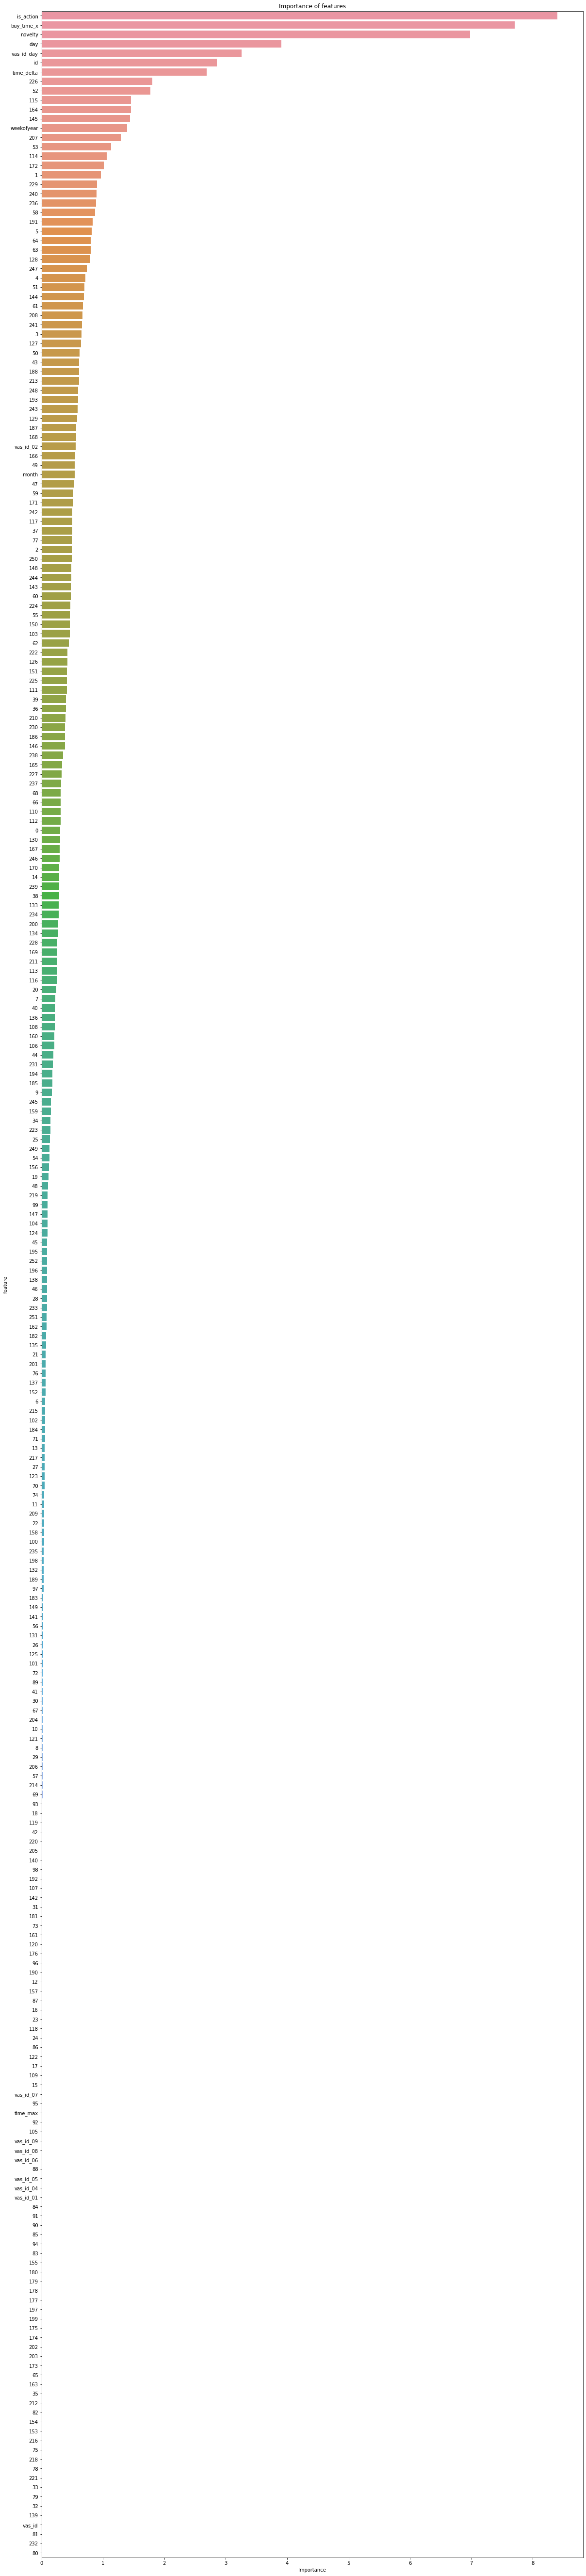

['is_action', 'buy_time_x', 'novelty', 'day', 'vas_id_day']

In [108]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [109]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [110]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb2)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

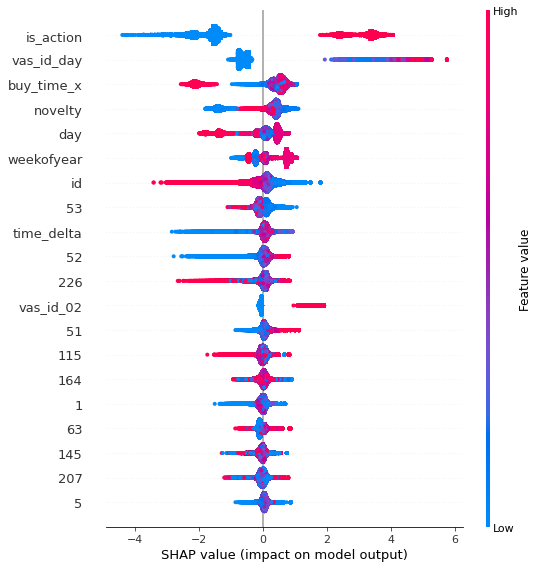

In [111]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


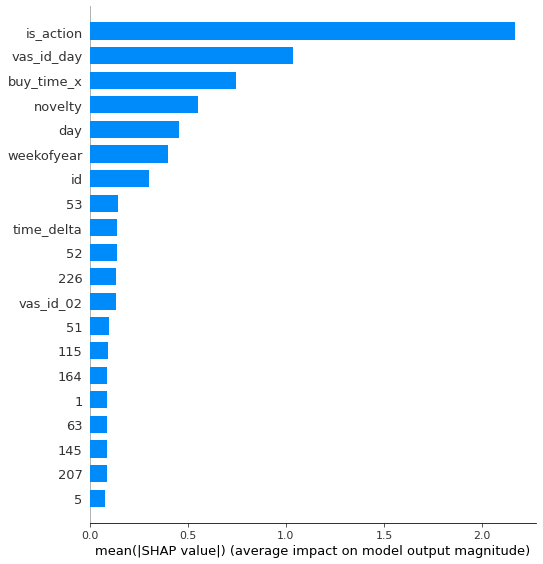

In [112]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [44]:
# Закладка
train_df2 = pd.concat([X_train, y_train], axis=1)
test_df2 = pd.concat([X_test, y_test], axis=1)
train_df2.to_csv('train_df2.csv', index=False)
test_df2.to_csv('test_df2.csv', index=False)

In [45]:
train_df2 = pd.read_csv('train_df2.csv')
test_df2 = pd.read_csv('test_df2.csv')
X_test = test_df2.drop(columns=['target'])
y_test = test_df2['target']
X_train = train_df2.drop(columns=['target'])
y_train = train_df2['target']

In [46]:
feature_importances = train_evaluate_preds(model_catb2, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.59      0.62      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.80      0.80    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97229   846
1.0       747  1197


In [47]:
X_train.isna().sum().sum()

0

In [48]:
X_test.isna().sum().sum()

0

# Подбор гиперпараметров

На Катбусте полное переобучение. Буду искать параметры при низких  max_depth

In [118]:
params = {'iterations':[50, 100, 200, 500, 1000],
          'depth':[3],
          #'learning_rate' : [0.03, 0.07, 0.1, 0.12],
          'l2_leaf_reg': [0.1, 1, 2, 4]}

In [119]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [120]:
frozen_params2 = {
     'class_weights':[1, 1], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [121]:
model_catb = catb.CatBoostClassifier(**frozen_params2)

In [122]:
grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.783459881
bestIteration = 0

0:	loss: 0.7834599	best: 0.7834599 (0)	total: 7.56s	remaining: 2m 23s

bestTest = 0.783459881
bestIteration = 0

1:	loss: 0.7834599	best: 0.7834599 (0)	total: 14.2s	remaining: 2m 8s

bestTest = 0.783459881
bestIteration = 0

2:	loss: 0.7834599	best: 0.7834599 (0)	total: 19.8s	remaining: 1m 52s

bestTest = 0.783459881
bestIteration = 0

3:	loss: 0.7834599	best: 0.7834599 (0)	total: 25.3s	remaining: 1m 41s

bestTest = 0.7949994959
bestIteration = 96

4:	loss: 0.7949995	best: 0.7949995 (4)	total: 36.3s	remaining: 1m 48s

bestTest = 0.7954110899
bestIteration = 96

5:	loss: 0.7954111	best: 0.7954111 (5)	total: 47s	remaining: 1m 49s

bestTest = 0.7952797132
bestIteration = 95

6:	loss: 0.7952797	best: 0.7954111 (5)	total: 57.7s	remaining: 1m 47s

bestTest = 0.7953611984
bestIteration = 95

7:	loss: 0.7953612	best: 0.7954111 (5)	total: 1m 8s	remaining: 1m 42s

bestTest = 0.8028605102
bestIteration = 195

8:	loss: 0.8028605	best: 0.8028605 (8)	total:

In [123]:
cv_results = pd.DataFrame(grid_search["cv_results"])

In [124]:
grid_search.get('params')

{'depth': 3, 'iterations': 1000, 'l2_leaf_reg': 0.1}

In [131]:
best_model3 = catb.CatBoostClassifier(**frozen_params2, depth = 3, iterations = 1000)

In [138]:
feature_importances = train_evaluate_preds(best_model3, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    146633
         1.0       0.98      0.94      0.96    145503

    accuracy                           0.96    292136
   macro avg       0.96      0.96      0.96    292136
weighted avg       0.96      0.96      0.96    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     98075
         1.0       0.34      0.66      0.45      1944

    accuracy                           0.97    100019
   macro avg       0.67      0.82      0.72    100019
weighted avg       0.98      0.97      0.97    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     95634  2441
1.0       665  1279


In [129]:
best_model31 = catb.CatBoostClassifier(**frozen_params2, depth = 3, l2_leaf_reg = 1, iterations = 500)

In [130]:
feature_importances = train_evaluate_preds(best_model31, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87    146633
         1.0       0.96      0.73      0.83    145503

    accuracy                           0.85    292136
   macro avg       0.87      0.85      0.85    292136
weighted avg       0.87      0.85      0.85    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     98075
         1.0       0.30      0.67      0.42      1944

    accuracy                           0.96    100019
   macro avg       0.65      0.82      0.70    100019
weighted avg       0.98      0.96      0.97    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     95099  2976
1.0       647  1297


In [133]:
params5 = {'iterations':[50, 100, 200, 500, 1000],
          'depth':[5],
          #'learning_rate' : [0.03, 0.07, 0.1, 0.12],
          'l2_leaf_reg': [0.1,1,2,4]}

In [134]:
model_catb5 = catb.CatBoostClassifier(**frozen_params2)

In [135]:
grid_search = model_catb5.randomized_search(params5, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8074065736
bestIteration = 4

0:	loss: 0.8074066	best: 0.8074066 (0)	total: 9.35s	remaining: 2m 57s

bestTest = 0.8074065736
bestIteration = 4

1:	loss: 0.8074066	best: 0.8074066 (0)	total: 17.6s	remaining: 2m 38s

bestTest = 0.8074065736
bestIteration = 4

2:	loss: 0.8074066	best: 0.8074066 (0)	total: 26.3s	remaining: 2m 29s

bestTest = 0.8073308447
bestIteration = 2

3:	loss: 0.8073308	best: 0.8074066 (0)	total: 34.8s	remaining: 2m 19s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8074065736
bestIteration = 4

4:	loss: 0.8074066	best: 0.8074066 (0)	total: 45s	remaining: 2m 14s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8074065736
bestIteration = 4

5:	loss: 0.8074066	best: 0.8074066 (0)	total: 55.6s	remaining: 2m 9s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8074065736
bestIteration = 4

6:	loss: 0.8074066	best: 0.8074066 (0)	total: 1m 5s	remaining: 2m 2s
Stopped by overfitting detector  (60 iterati

In [136]:
cv_results = pd.DataFrame(grid_search["cv_results"])

In [137]:
grid_search.get('params')

{'depth': 5, 'iterations': 50, 'l2_leaf_reg': 0.1}

In [141]:
best_model5 = catb.CatBoostClassifier(**frozen_params2, depth = 5, l2_leaf_reg = 0.1, iterations = 50)

In [142]:
feature_importances = train_evaluate_preds(best_model5, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.76      0.96      0.85    146633
         1.0       0.94      0.70      0.80    145503

    accuracy                           0.83    292136
   macro avg       0.85      0.83      0.83    292136
weighted avg       0.85      0.83      0.83    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     98075
         1.0       0.24      0.69      0.35      1944

    accuracy                           0.95    100019
   macro avg       0.62      0.82      0.66    100019
weighted avg       0.98      0.95      0.96    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     93808  4267
1.0       605  1339


In [143]:
params9 = {'iterations':[50, 100, 200, 500, 1000],
          'depth':[9],
          #'learning_rate' : [0.03, 0.07, 0.1, 0.12],
          'l2_leaf_reg': [0.1,1,2,4]}

In [144]:
model_catb9 = catb.CatBoostClassifier(**frozen_params2)

In [145]:
grid_search = model_catb9.randomized_search(params9, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8326408126
bestIteration = 49

0:	loss: 0.8326408	best: 0.8326408 (0)	total: 21.6s	remaining: 6m 49s

bestTest = 0.827460628
bestIteration = 49

1:	loss: 0.8274606	best: 0.8326408 (0)	total: 41.1s	remaining: 6m 10s

bestTest = 0.8308783627
bestIteration = 49

2:	loss: 0.8308784	best: 0.8326408 (0)	total: 1m	remaining: 5m 44s

bestTest = 0.8303020902
bestIteration = 48

3:	loss: 0.8303021	best: 0.8326408 (0)	total: 1m 21s	remaining: 5m 24s

bestTest = 0.9042472163
bestIteration = 99

4:	loss: 0.9042472	best: 0.9042472 (4)	total: 2m 1s	remaining: 6m 4s

bestTest = 0.8918103924
bestIteration = 99

5:	loss: 0.8918104	best: 0.9042472 (4)	total: 2m 41s	remaining: 6m 16s

bestTest = 0.891359347
bestIteration = 99

6:	loss: 0.8913593	best: 0.9042472 (4)	total: 3m 21s	remaining: 6m 14s

bestTest = 0.8795317713
bestIteration = 99

7:	loss: 0.8795318	best: 0.9042472 (4)	total: 4m 1s	remaining: 6m 2s

bestTest = 0.9794157273
bestIteration = 199

8:	loss: 0.9794157	best: 0.9794157 (8)

KeyboardInterrupt: 

In [ ]:
cv_results = pd.DataFrame(grid_search["cv_results"])

In [ ]:
grid_search.get('params')

In [146]:
best_model9 = catb.CatBoostClassifier(**frozen_params2, depth = 9, l2_leaf_reg = 0.1, iterations = 100)

In [147]:
feature_importances = train_evaluate_preds(best_model9, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92    146633
         1.0       0.97      0.85      0.91    145503

    accuracy                           0.91    292136
   macro avg       0.92      0.91      0.91    292136
weighted avg       0.92      0.91      0.91    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     98075
         1.0       0.32      0.66      0.43      1944

    accuracy                           0.97    100019
   macro avg       0.66      0.82      0.71    100019
weighted avg       0.98      0.97      0.97    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     95401  2674
1.0       665  1279


In [148]:
best_model91 = catb.CatBoostClassifier(**frozen_params2, depth = 9, l2_leaf_reg = 0.1, iterations = 200)

In [149]:
feature_importances = train_evaluate_preds(best_model91, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    146633
         1.0       0.98      0.97      0.98    145503

    accuracy                           0.98    292136
   macro avg       0.98      0.98      0.98    292136
weighted avg       0.98      0.98      0.98    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     98075
         1.0       0.39      0.64      0.48      1944

    accuracy                           0.97    100019
   macro avg       0.69      0.81      0.74    100019
weighted avg       0.98      0.97      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     96119  1956
1.0       699  1245


In [150]:
best_model92 = catb.CatBoostClassifier(**frozen_params2, depth = 9, l2_leaf_reg = 0.1, iterations = 500)

In [151]:
feature_importances = train_evaluate_preds(best_model92, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.57      0.61      0.59      1944

    accuracy                           0.98    100019
   macro avg       0.78      0.80      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97193   882
1.0       757  1187


С подбором параметров ничего не получилось.

In [52]:
feature_importances = train_evaluate_preds(model_catb2, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    146633
         1.0       0.99      1.00      1.00    145503

    accuracy                           1.00    292136
   macro avg       1.00      1.00      1.00    292136
weighted avg       1.00      1.00      1.00    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.59      0.62      0.60      1944

    accuracy                           0.98    100019
   macro avg       0.79      0.80      0.80    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97229   846
1.0       747  1197


# Снижение степени переобучения

меняю class_weights:

In [49]:
frozen_params3 = {
     'class_weights':[1, 0.1], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [50]:
best_model = catb.CatBoostClassifier(**frozen_params3)

In [51]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    146633
         1.0       1.00      0.92      0.96    145503

    accuracy                           0.96    292136
   macro avg       0.96      0.96      0.96    292136
weighted avg       0.96      0.96      0.96    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.62      0.57      0.59      1944

    accuracy                           0.98    100019
   macro avg       0.80      0.78      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97392   683
1.0       841  1103


In [191]:
from matplotlib import pyplot

In [198]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = catb.CatBoostClassifier(learning_rate=r, **frozen_params3)
    return models

In [199]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [200]:
# get the models to evaluate
models = get_models()

In [202]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.794 (0.002)
>0.0010 0.803 (0.002)
>0.0100 0.817 (0.001)
>0.1000 0.936 (0.001)
>1.0000 0.997 (0.000)


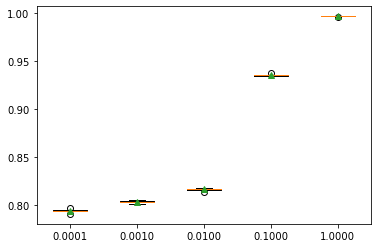

In [203]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [204]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = [0.1,1,2,4,8]
    for t in types:
        models[t] = catb.CatBoostClassifier(l2_leaf_reg=t, **frozen_params3)
    return models

In [205]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [206]:
# get the models to evaluate
models = get_models()

In [207]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.1 0.851 (0.002)
>1 0.843 (0.002)
>2 0.840 (0.002)
>4 0.837 (0.002)
>8 0.832 (0.002)


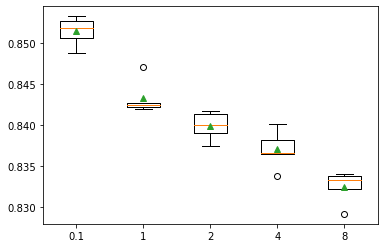

In [208]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [210]:
params = {'learning_rate' : [0.001, 0.01, 0.1],
          'l2_leaf_reg': [1,2,4]}

In [211]:
model = catb.CatBoostClassifier(**frozen_params3)

In [212]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.7254704035
bestIteration = 0

0:	loss: 0.7254704	best: 0.7254704 (0)	total: 11.9s	remaining: 1m 35s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.7487428272
bestIteration = 224

1:	loss: 0.7487428	best: 0.7487428 (1)	total: 1m 2s	remaining: 3m 38s

bestTest = 0.9189702838
bestIteration = 999

2:	loss: 0.9189703	best: 0.9189703 (2)	total: 3m 37s	remaining: 7m 14s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.7254704035
bestIteration = 0

3:	loss: 0.7254704	best: 0.9189703 (2)	total: 3m 47s	remaining: 4m 44s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.7488175947
bestIteration = 210

4:	loss: 0.7488176	best: 0.9189703 (2)	total: 4m 32s	remaining: 3m 37s

bestTest = 0.9093152165
bestIteration = 999

5:	loss: 0.9093152	best: 0.9189703 (2)	total: 7m 17s	remaining: 3m 38s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.7254704035
bestItera

In [213]:
grid_search.get('params')

{'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [214]:
model1 = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 1, learning_rate = 0.1)

In [215]:
feature_importances = train_evaluate_preds(model1, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    146633
         1.0       1.00      0.92      0.95    145503

    accuracy                           0.96    292136
   macro avg       0.96      0.96      0.96    292136
weighted avg       0.96      0.96      0.96    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.63      0.56      0.59      1944

    accuracy                           0.98    100019
   macro avg       0.81      0.78      0.79    100019
weighted avg       0.98      0.98      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97432   643
1.0       861  1083


In [216]:
model2 = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 2, learning_rate = 0.1)

In [217]:
feature_importances = train_evaluate_preds(model2, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    146633
         1.0       1.00      0.90      0.94    145503

    accuracy                           0.95    292136
   macro avg       0.95      0.95      0.95    292136
weighted avg       0.95      0.95      0.95    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.63      0.57      0.60      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.78      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97426   649
1.0       836  1108


In [218]:
model3 = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 4, learning_rate = 0.1)

In [219]:
feature_importances = train_evaluate_preds(model3, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95    146633
         1.0       0.99      0.89      0.94    145503

    accuracy                           0.94    292136
   macro avg       0.95      0.94      0.94    292136
weighted avg       0.95      0.94      0.94    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.62      0.57      0.60      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.78      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97406   669
1.0       830  1114


In [67]:
frozen_params3 = {
     'class_weights':[1, 0.1], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [68]:
model4 = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 6, learning_rate = 0.1)

In [69]:
feature_importances = train_evaluate_preds(model4, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94    146633
         1.0       0.99      0.88      0.93    145503

    accuracy                           0.94    292136
   macro avg       0.94      0.94      0.94    292136
weighted avg       0.94      0.94      0.94    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.62      0.59      0.61      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.79      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97377   698
1.0       797  1147


In [71]:
run_cv(model4, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.93 (+/- 0.00)


In [72]:
best_model  = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 6, learning_rate = 0.1)

In [73]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.501934
1.0    0.498066
Name: target, dtype: float64

0.0    0.980564
1.0    0.019436
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94    146633
         1.0       0.99      0.88      0.93    145503

    accuracy                           0.94    292136
   macro avg       0.94      0.94      0.94    292136
weighted avg       0.94      0.94      0.94    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.62      0.59      0.61      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.79      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97377   698
1.0       797  1147


# Подбор порога

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [74]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [75]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [76]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94    146633
         1.0       0.99      0.88      0.93    145503

    accuracy                           0.94    292136
   macro avg       0.94      0.94      0.94    292136
weighted avg       0.94      0.94      0.94    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.62      0.59      0.61      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.79      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     97377   698
1.0       797  1147


In [77]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94    146633
         1.0       0.99      0.88      0.93    145503

    accuracy                           0.94    292136
   macro avg       0.94      0.94      0.94    292136
weighted avg       0.94      0.94      0.94    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.60      0.63      0.61      1944

    accuracy                           0.98    100019
   macro avg       0.80      0.81      0.80    100019
weighted avg       0.99      0.98      0.98    100019

CONFUSION MATRIX

col_0       0     1
target             
0.0     97256   819
1.0       719  1225
Best Threshold=0.261949


Не удалось повысить на метрику.

Написал функцию для тонкой настройки трешхолда

In [78]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [82]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.55)

TRAIN

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93    146633
         1.0       0.99      0.86      0.92    145503

    accuracy                           0.93    292136
   macro avg       0.94      0.93      0.93    292136
weighted avg       0.94      0.93      0.93    292136

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     98075
         1.0       0.63      0.58      0.60      1944

    accuracy                           0.99    100019
   macro avg       0.81      0.78      0.80    100019
weighted avg       0.98      0.99      0.98    100019

CONFUSION MATRIX

col_0       0     1
target             
0.0     97406   669
1.0       823  1121


(array([1, 1, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

Изменение трешхолда не помогло, из-за 1% уменьшения переобучения не стоит связываться..

In [83]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [84]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[97397   678]
 [  818  1126]]


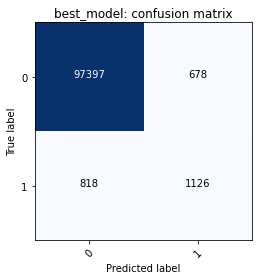

In [85]:
cm = confusion_matrix(y_test, y_test_poba > 0.54)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# Создаю пайплайн

На балансированных данных!

In [96]:
columns2 = ['id', 'vas_id', 'buy_time_x', '0', '1', '2', '3', '4', '5', '7', '8',
      '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
      '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
      '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
      '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
      '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73',
      '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86',
      '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99',
      '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110',
      '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121',
      '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132',
      '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143',
      '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154',
      '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165',
      '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176',
      '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187',
      '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198',
      '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209',
      '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220',
      '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231',
      '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242',
      '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', 'time_delta',
      'vas_id_01', 'vas_id_02', 'vas_id_04', 'vas_id_05', 'vas_id_06', 'vas_id_07',
      'vas_id_08', 'vas_id_09', 'month', 'day', 'weekofyear', 'time_max', 'novelty',
      'vas_id_day', 'is_action']

In [97]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [98]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [99]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns2))
            ])

In [100]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', catb.CatBoostClassifier(class_weights = [1, 0.1], random_state = 21, eval_metric = 'F1', l2_leaf_reg = 6, learning_rate = 0.1))
])

# Сохранение модели

In [101]:
import pickle

In [102]:
with open('model_2.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [103]:
with open('model_2.pkl', 'rb') as model:
    x = pickle.load(model)

In [104]:
x.fit(X_test, y_test)

0:	learn: 0.0000000	total: 76.3ms	remaining: 1m 16s
1:	learn: 0.0000000	total: 155ms	remaining: 1m 17s
2:	learn: 0.0000000	total: 225ms	remaining: 1m 14s
3:	learn: 0.0000000	total: 310ms	remaining: 1m 17s
4:	learn: 0.0000000	total: 381ms	remaining: 1m 15s
5:	learn: 0.0000000	total: 453ms	remaining: 1m 15s
6:	learn: 0.0000000	total: 531ms	remaining: 1m 15s
7:	learn: 0.0000000	total: 617ms	remaining: 1m 16s
8:	learn: 0.0020555	total: 691ms	remaining: 1m 16s
9:	learn: 0.1390476	total: 771ms	remaining: 1m 16s
10:	learn: 0.2738516	total: 840ms	remaining: 1m 15s
11:	learn: 0.2837066	total: 916ms	remaining: 1m 15s
12:	learn: 0.2904637	total: 1s	remaining: 1m 16s
13:	learn: 0.3067591	total: 1.08s	remaining: 1m 15s
14:	learn: 0.3067591	total: 1.17s	remaining: 1m 16s
15:	learn: 0.3074924	total: 1.26s	remaining: 1m 17s
16:	learn: 0.3074924	total: 1.36s	remaining: 1m 18s
17:	learn: 0.3263383	total: 1.46s	remaining: 1m 19s
18:	learn: 0.3270548	total: 1.55s	remaining: 1m 20s
19:	learn: 0.3270548	tot

159:	learn: 0.3538332	total: 13.3s	remaining: 1m 9s
160:	learn: 0.3538332	total: 13.4s	remaining: 1m 9s
161:	learn: 0.3552189	total: 13.5s	remaining: 1m 9s
162:	learn: 0.3552189	total: 13.5s	remaining: 1m 9s
163:	learn: 0.3552189	total: 13.6s	remaining: 1m 9s
164:	learn: 0.3552189	total: 13.7s	remaining: 1m 9s
165:	learn: 0.3559108	total: 13.8s	remaining: 1m 9s
166:	learn: 0.3559108	total: 13.8s	remaining: 1m 9s
167:	learn: 0.3559108	total: 13.9s	remaining: 1m 8s
168:	learn: 0.3559108	total: 14s	remaining: 1m 8s
169:	learn: 0.3559108	total: 14.1s	remaining: 1m 8s
170:	learn: 0.3559108	total: 14.1s	remaining: 1m 8s
171:	learn: 0.3559108	total: 14.2s	remaining: 1m 8s
172:	learn: 0.3559108	total: 14.3s	remaining: 1m 8s
173:	learn: 0.3559108	total: 14.4s	remaining: 1m 8s
174:	learn: 0.3559108	total: 14.5s	remaining: 1m 8s
175:	learn: 0.3559108	total: 14.6s	remaining: 1m 8s
176:	learn: 0.3559108	total: 14.6s	remaining: 1m 8s
177:	learn: 0.3559108	total: 14.7s	remaining: 1m 8s
178:	learn: 0.

319:	learn: 0.3634841	total: 25.8s	remaining: 54.9s
320:	learn: 0.3634841	total: 25.9s	remaining: 54.8s
321:	learn: 0.3634841	total: 26s	remaining: 54.8s
322:	learn: 0.3634841	total: 26.1s	remaining: 54.7s
323:	learn: 0.3634841	total: 26.2s	remaining: 54.6s
324:	learn: 0.3634841	total: 26.3s	remaining: 54.5s
325:	learn: 0.3634841	total: 26.3s	remaining: 54.4s
326:	learn: 0.3634841	total: 26.4s	remaining: 54.3s
327:	learn: 0.3634841	total: 26.4s	remaining: 54.2s
328:	learn: 0.3655374	total: 26.5s	remaining: 54.1s
329:	learn: 0.3662207	total: 26.6s	remaining: 54s
330:	learn: 0.3662207	total: 26.7s	remaining: 53.9s
331:	learn: 0.3655374	total: 26.8s	remaining: 53.8s
332:	learn: 0.3655374	total: 26.8s	remaining: 53.7s
333:	learn: 0.3655374	total: 26.9s	remaining: 53.7s
334:	learn: 0.3655374	total: 27s	remaining: 53.6s
335:	learn: 0.3655374	total: 27.1s	remaining: 53.5s
336:	learn: 0.3662207	total: 27.1s	remaining: 53.4s
337:	learn: 0.3662207	total: 27.2s	remaining: 53.3s
338:	learn: 0.3662

480:	learn: 0.3723449	total: 38.2s	remaining: 41.2s
481:	learn: 0.3723449	total: 38.2s	remaining: 41.1s
482:	learn: 0.3723449	total: 38.3s	remaining: 41s
483:	learn: 0.3723449	total: 38.4s	remaining: 40.9s
484:	learn: 0.3723449	total: 38.5s	remaining: 40.8s
485:	learn: 0.3723449	total: 38.5s	remaining: 40.8s
486:	learn: 0.3723449	total: 38.6s	remaining: 40.7s
487:	learn: 0.3723449	total: 38.7s	remaining: 40.6s
488:	learn: 0.3723449	total: 38.8s	remaining: 40.5s
489:	learn: 0.3723449	total: 38.8s	remaining: 40.4s
490:	learn: 0.3723449	total: 38.9s	remaining: 40.3s
491:	learn: 0.3723449	total: 39s	remaining: 40.3s
492:	learn: 0.3723449	total: 39.1s	remaining: 40.2s
493:	learn: 0.3723449	total: 39.1s	remaining: 40.1s
494:	learn: 0.3723449	total: 39.2s	remaining: 40s
495:	learn: 0.3730225	total: 39.3s	remaining: 39.9s
496:	learn: 0.3730225	total: 39.4s	remaining: 39.8s
497:	learn: 0.3730225	total: 39.4s	remaining: 39.8s
498:	learn: 0.3730225	total: 39.5s	remaining: 39.7s
499:	learn: 0.3730

640:	learn: 0.3757273	total: 49.7s	remaining: 27.8s
641:	learn: 0.3757273	total: 49.8s	remaining: 27.8s
642:	learn: 0.3757273	total: 49.8s	remaining: 27.7s
643:	learn: 0.3757273	total: 49.9s	remaining: 27.6s
644:	learn: 0.3757273	total: 50s	remaining: 27.5s
645:	learn: 0.3757273	total: 50.1s	remaining: 27.4s
646:	learn: 0.3757273	total: 50.1s	remaining: 27.3s
647:	learn: 0.3757273	total: 50.2s	remaining: 27.3s
648:	learn: 0.3757273	total: 50.3s	remaining: 27.2s
649:	learn: 0.3757273	total: 50.3s	remaining: 27.1s
650:	learn: 0.3757273	total: 50.4s	remaining: 27s
651:	learn: 0.3757273	total: 50.5s	remaining: 26.9s
652:	learn: 0.3757273	total: 50.6s	remaining: 26.9s
653:	learn: 0.3757273	total: 50.6s	remaining: 26.8s
654:	learn: 0.3757273	total: 50.7s	remaining: 26.7s
655:	learn: 0.3757273	total: 50.8s	remaining: 26.6s
656:	learn: 0.3757273	total: 50.9s	remaining: 26.6s
657:	learn: 0.3757273	total: 50.9s	remaining: 26.5s
658:	learn: 0.3757273	total: 51s	remaining: 26.4s
659:	learn: 0.3757

802:	learn: 0.3837883	total: 1m 1s	remaining: 15.2s
803:	learn: 0.3837883	total: 1m 1s	remaining: 15.1s
804:	learn: 0.3837883	total: 1m 1s	remaining: 15s
805:	learn: 0.3837883	total: 1m 2s	remaining: 14.9s
806:	learn: 0.3837883	total: 1m 2s	remaining: 14.8s
807:	learn: 0.3837883	total: 1m 2s	remaining: 14.8s
808:	learn: 0.3837883	total: 1m 2s	remaining: 14.7s
809:	learn: 0.3837883	total: 1m 2s	remaining: 14.6s
810:	learn: 0.3837883	total: 1m 2s	remaining: 14.5s
811:	learn: 0.3837883	total: 1m 2s	remaining: 14.5s
812:	learn: 0.3837883	total: 1m 2s	remaining: 14.4s
813:	learn: 0.3837883	total: 1m 2s	remaining: 14.3s
814:	learn: 0.3837883	total: 1m 2s	remaining: 14.2s
815:	learn: 0.3837883	total: 1m 2s	remaining: 14.1s
816:	learn: 0.3844564	total: 1m 2s	remaining: 14.1s
817:	learn: 0.3844564	total: 1m 2s	remaining: 14s
818:	learn: 0.3844564	total: 1m 2s	remaining: 13.9s
819:	learn: 0.3844564	total: 1m 3s	remaining: 13.8s
820:	learn: 0.3844564	total: 1m 3s	remaining: 13.8s
821:	learn: 0.38

960:	learn: 0.3871234	total: 1m 13s	remaining: 3s
961:	learn: 0.3871234	total: 1m 14s	remaining: 2.93s
962:	learn: 0.3871234	total: 1m 14s	remaining: 2.85s
963:	learn: 0.3871234	total: 1m 14s	remaining: 2.77s
964:	learn: 0.3871234	total: 1m 14s	remaining: 2.69s
965:	learn: 0.3871234	total: 1m 14s	remaining: 2.62s
966:	learn: 0.3871234	total: 1m 14s	remaining: 2.54s
967:	learn: 0.3871234	total: 1m 14s	remaining: 2.46s
968:	learn: 0.3871234	total: 1m 14s	remaining: 2.39s
969:	learn: 0.3877888	total: 1m 14s	remaining: 2.31s
970:	learn: 0.3877888	total: 1m 14s	remaining: 2.23s
971:	learn: 0.3877888	total: 1m 14s	remaining: 2.16s
972:	learn: 0.3877888	total: 1m 15s	remaining: 2.08s
973:	learn: 0.3877888	total: 1m 15s	remaining: 2s
974:	learn: 0.3877888	total: 1m 15s	remaining: 1.93s
975:	learn: 0.3877888	total: 1m 15s	remaining: 1.85s
976:	learn: 0.3884536	total: 1m 15s	remaining: 1.77s
977:	learn: 0.3884536	total: 1m 15s	remaining: 1.7s
978:	learn: 0.3884536	total: 1m 15s	remaining: 1.62s


Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['id', 'vas_id',
                                                      'buy_time_x', '0', '1',
                                                      '2', '3', '4', '5', '7',
                                                      '8', '9', '10', '11',
                                                      '12', '13', '14', '15',
                                                      '16', '17', '18', '19',
                                                      '20', '21', '22', '23',
                                                      '24', '25', '26', '27', ...]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f627a441790>)])

Confusion matrix, without normalization
[[98074     1]
 [ 1471   473]]


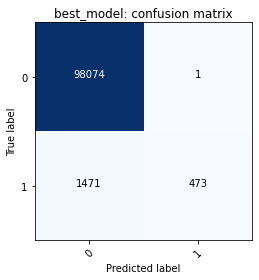

In [105]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

In [ ]:
Упс, с пайплайном не срослась метрика.

In [ ]:
frozen_params3 = {
     'class_weights':[1, 0.1], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [ ]:
best_model  = catb.CatBoostClassifier(**frozen_params3, l2_leaf_reg = 6, learning_rate = 0.1)

In [ ]:
with open('model2.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [ ]:
with open('model2.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");